<a href="https://colab.research.google.com/github/majensen/sp-project/blob/main/examples/03-tissue-masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Masking tissue region in whole slide images

Click to open in: \[[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/03-tissue-masking.ipynb)\]\[[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/develop/examples/03-tissue-masking.ipynb)\]



## About this notebook

This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.



### About this demo

In this example, we will show how you can use tiatoolbox to easily find the tissue region in a whole slide image. Apart from tissue regions, WSIs usually show large blank (glass) background areas that contain no information. Therefore, it is essential to detect the informative (tissue) region in the WSI before any action (like patch extraction and classification). We call this step, "tissue masking". In particular, we introduce the use of our module
`tissuemask` ([details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/tools/tissuemask.py)) which distinguishes tissue from glass, using an automatic image thresholding algorithm ([Otsu's method](https://learnopencv.com/otsu-thresholding-with-opencv/)) and some morphological operations.



## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [1]:
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
echo "Installation is done."


Installation is done.


  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-ip7pgh26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
jupyter-kernel-gateway 2.5.2 requires jupyter-client<8.0,>=5.2.0, but you have jupyter-client 8.6.3 which is incompatible.


**IMPORTANT**: If you are using Colab and you run the cell above for the first time, please note that you need to restart the runtime before proceeding through (menu) *Runtime→Restart runtime* . This is needed to load the latest versions of prerequisite packages installed with TIAToolbox. Doing so, you should be able to run all the remaining cells altogether (*Runtime→Run after* from the next cell) or one by one.



### Removing leftovers from previous runs

The following code cell removes the directory `tmp` if it exists—a previous run may have created it. The cell can be skipped if you are running this notebook for the first time.



In [1]:
%%bash
rm -rf tmp
echo "deleting tmp directory"

deleting tmp directory


### Importing related libraries

We will start by importing some libraries required to run this notebook.



In [2]:
"""Import modules required to run the Jupyter notebook."""

from __future__ import annotations

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import requests

from tiatoolbox.tools.tissuemask import MorphologicalMasker
from tiatoolbox.utils import imwrite
from tiatoolbox.wsicore.wsireader import WSIReader

mpl.rcParams["figure.dpi"] = 150  # for high resolution figure in notebook

### Downloading the required files

The next cell creates a temporary directory `tmp` and downloads to that directory, from the internet, an image file. The code illustrates a standard programming technique, designed to minimize the harmful effects of "hard-coding" choices that a user might like to change. Our choices are made explicitly only once, to minimize the amount of editing needed by a user with different choices. The choices are encoded in python variables, in this case `data_dir` and `sample_file_name`, which do not need to be changed when the choices change, and which are used when repetition is needed.

If the notebook is run a second time, the `tmp` directory will be deleted (see above). Cleaning up, after a program is run, is easier when all temporary data is collected at a single point, in this case in the directory `tmp`.



In [3]:
data_dir = "./tmp"
sample_file_name = "sample_wsi_small.svs"
sample_thumbnail_name = "sample_wsi_small_thumbnail.jpg"
sample_mask_name = "sample_wsi_small_mask.png"

user_sample_wsi_path = None
if user_sample_wsi_path is None:
    sample_wsi_path = f"{data_dir}/{sample_file_name}"
else:
    sample_wsi_path = user_sample_wsi_path
if not Path(sample_wsi_path).exists():
    Path(data_dir).mkdir()
    r = requests.get(
        "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/CMU-1-Small-Region.svs",
        timeout=60,  # 60s
    )
    with Path(sample_wsi_path).open("wb") as f:
        f.write(r.content)

sample_thumbnail_path = f"{data_dir}/{sample_thumbnail_name}"
sample_mask_path = f"{data_dir}/{sample_mask_name}"

## Reading a WSI and its Thumbnail

The toolbox provides a common interface for different whole slide image file formats produced by different vendors. The functions `WSIReader.open` takes a file path to an image as input and returns an instance of the appropriate subclass of WSIReader. For more information about WSI reading in tiatoolbox, please refer to the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader) and the [notebook example](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/01-wsi-reading.ipynb) dedicated to this topic.



In [4]:
wsi = WSIReader.open(input_img=sample_wsi_path)
print(type(wsi))  # noqa: T201

<class 'tiatoolbox.wsicore.wsireader.OpenSlideWSIReader'>


From the output of the cell above, note that the python variable `wsi` does not refer to an unadorned WSI, but to a more complex object possessing a number of very useful class methods, enabling it to conveniently read various aspects of the image. First, let's check the basic WSI information, such as magnification, dimension, etc. (mpp= microns per pixel).



In [6]:
wsi_info = wsi.info.as_dict()
# Print one item per line
print(*list(wsi_info.items()), sep="\n")  # noqa: T201

('objective_power', 20.0)
('slide_dimensions', (2220, 2967))
('level_count', 1)
('level_dimensions', ((2220, 2967),))
('level_downsamples', [1.0])
('vendor', 'aperio')
('mpp', (0.499, 0.499))
('file_path', PosixPath('tmp/sample_wsi_small.svs'))
('axes', 'YXS')


Working with `tiatoolbox`, it is easy to load a WSI thumbnail using the `slide_thumbnail` method of the `wsi` object. The thumbnail can be loaded with a different magnification, using a convenient choice of coordinates to indicate the resolution. The following options are available for the `units` argument:

- `mpp`: microns per pixel
- `power`: objective power (magnification)
- `level`: the level in the WSI pyramidal file
- `baseline`: pixels per baseline pixel. A *baseline pixel* is a pixel in the level (zero) of the greatest available magnification in this WSI.

We load and show the thumbnail at $\times1.25$ objective power as follows:



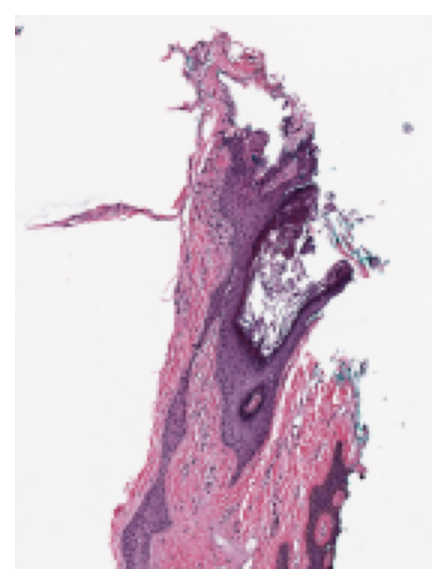

In [7]:
wsi_thumb = wsi.slide_thumbnail(resolution=1.25, units="power")
plt.imshow(wsi_thumb)
plt.axis("off")
plt.show()

## Generating tissue mask in 1 line of code

The task is to distinguish between tissue and glass (no tissue) in the WSI. We compute a mask, by which we mean a binary colouring of the pixels to either blue=glass or yellow=tissue. Generating the tissue mask for a WSI using tiatoolbox is as simple as the following line of code:



In [8]:
mask = wsi.tissue_mask(resolution=1.25, units="power")

The two Python variables `mask` and `wsi` are both instances of the class `WSIReader`, and therefore have the same attributes, and can be treated in the same way. For example, we can visualize the original image and the mask next to each other at the same resolution and at the same size. Now, let's see the thumbnails of the original `wsi` and its `mask` at the same resolution.



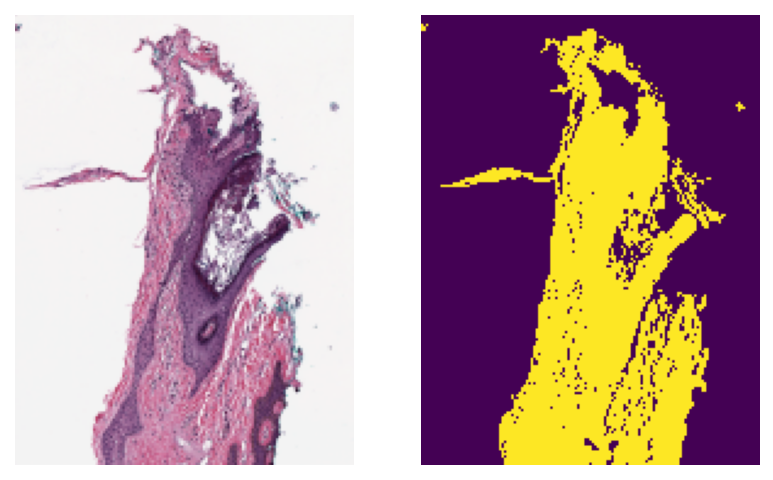

In [9]:
mask_thumb = mask.slide_thumbnail(
    resolution=1.25,
    units="power",
)  # extracting the mask_thumb at the same resolution as wsi_thumb


# showing the result
def show_side_by_side(image_1: np.ndarray, image_2: np.ndarray) -> None:
    """Helper function to shows images side-by-side."""
    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(image_2)
    plt.axis("off")
    plt.show()


show_side_by_side(wsi_thumb, mask_thumb)

As you can see, the generated mask resembles the tissue area of the original WSI pretty closely. This kind of mask is usually used in digital pathology pipelines to specify the regions from which to extract patches at high resolution. Besides, extracting thumbnails, we can also extract regions from the `mask` object in the same way that we do for the `wsi` object:



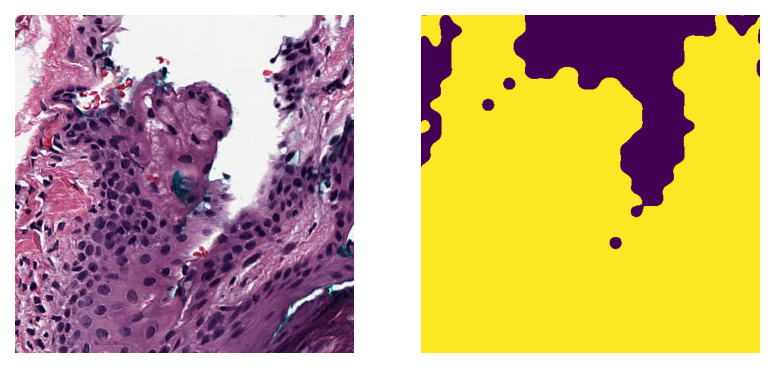

In [10]:
wsi_region = wsi.read_region(location=(1024, 512), level=0, size=(512, 512))
mask_region = mask.read_region(location=(1024, 512), level=0, size=(512, 512))

show_side_by_side(wsi_region, mask_region)

As expected, the coordinates of the original `wsi` and the `mask` line up precisely. This can be particularly useful if you want to calculate statistics of the tissue region in a patch (e.g., tissue area, intensity, and texture information).

There are some options (arguments) that can be used when calling `tissue_mask()` to achieve a more detailed tissue mask in high resolution or to remove small objects from the tissue mask. This will be explained in the next section.



# Saving tissue thumbail and mask

We can use `imwrite` method from `tiatoolbox.utils` to save thumbnail and mask images. Note, while thumbnails can be saved using a **lossy** compression as JPEG files, masks should be saved using **lossless compression** as PNG files to preserve the binary nature of the mask values (0 and 255).



In [11]:
imwrite(sample_thumbnail_path, wsi_thumb)
imwrite(sample_mask_path, mask_thumb.astype(np.uint8) * 255)

## Generating tissue masks for batch

Utilizing the functionalities in the `tissuemask` tool of the tiatoolbox, we can extract tissue masks for a batch of images. Here we use `MorphologicalMasker` to generate tissue masks for a list of input image regions.

First, we extract two different regions from the `wsi`. This is our batch of (only two) images to be processed using [read_rect](https://tia-toolbox.readthedocs.io/en/latest/_autosummary/tiatoolbox.wsicore.wsireader.WSIReader.html#tiatoolbox.wsicore.wsireader.WSIReader.read_rect). We then instantiate a `MorphologicalMasker` object to be used in a later cell for extraction of masks from the batch:



In [ ]:
# extracting the regions
mag_power = 20  # magnification power to extract patches and calculate the kernel_size
region1 = wsi.read_rect(
    location=(1024, 256),
    size=(512, 512),
    resolution=mag_power,
    units="power",
)
region2 = wsi.read_rect(
    location=(1536, 2048),
    size=(512, 512),
    resolution=mag_power,
    units="power",
)

# instantiating a MorphologicalMasker
masker = MorphologicalMasker(power=mag_power)

Now, let's apply the `masker` on the extracted patches:



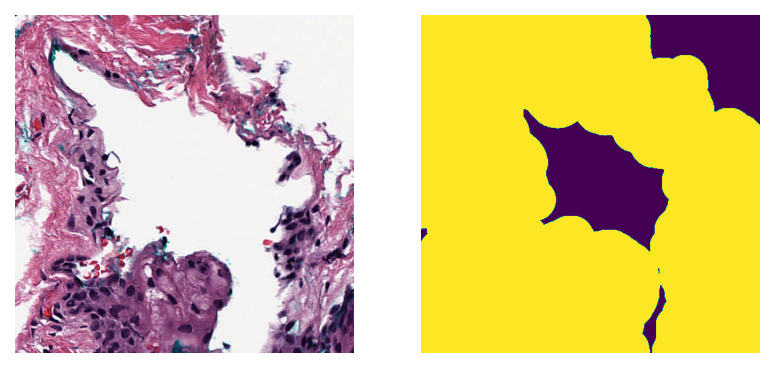

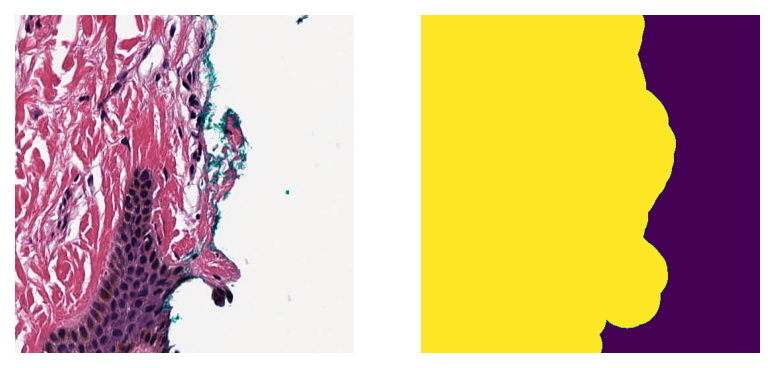

In [ ]:
masks = masker.fit_transform([region1, region2])

# showing the results
show_side_by_side(region1, masks[0])
show_side_by_side(region2, masks[1])

An optimal threshold is found by `fit_transform` using Otsu's method. This is followed by deleting small objects and applying morphological dilation. Dilation results in overflow of the true boundaries of tissue regions. The overflow is deliberate, because we prefer not to miss tissue information.

The `fit_transform` function expects inputs that are (lists of) `numpy` arrays. That is why the inputs are enclosed by square brackets, *eg* `masker.fit_transform([region1, region2])`. The `fit_transform` function accepts a list of RGB images or a numpy array in the expected shape of N$\times$H$\times$W$\times$C (number of images, height, width, channels). It outputs a list of tissue masks

`MorphologicalMasker` can be used with different __optional__ arguments:

- `kernel_size`: Size of the elliptical kernel to be used for morphological operations in mask post-processing.
- `mpp`: The microns per pixel of the image to be masked. Used to calculate `kernel_size`.
- `power`: The objective power of the image to be masked. Used to calculate `kernel_size`.
- `min_region_size`: Minimum region size in pixels to consider as foreground.

_Note_ that only one of the named arguments `kernel_size`, `mpp`, or `power` should be used. Only the `kernel_size` is needed in morphological operations; the other two possible arguments are used only to calculate a suitable `kernel_size`.
More information can be found in the definition of [tissuemask](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/tools/tissuemask.py).

Next we compute the mask of `wsi_thumb` using `MorphologicalMasker` and investigate the effect of changing parameters on the outputs:



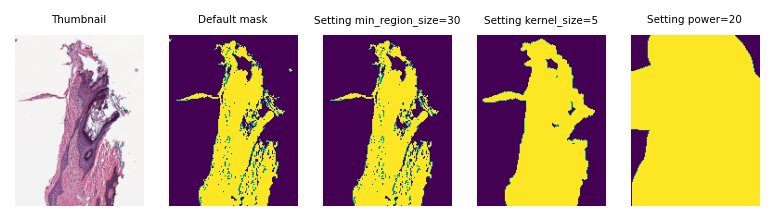

In [ ]:
def make_subplot(image: np.ndarray, title: str, k: int) -> None:
    """Make a 1x5 subplot."""
    plt.subplot(1, 5, k)
    plt.imshow(image)
    plt.axis("off")
    plt.title(title, fontdict={"fontsize": 5})


# default: kernel_size=1, min_region_size=1
masker = MorphologicalMasker()
masks_default = masker.fit_transform([wsi_thumb])

# meaning deleting objects smaller than 30 pixels in area
masker = MorphologicalMasker(min_region_size=30)
masks_small = masker.fit_transform([wsi_thumb])

# applying morphological dilation with a elliptical kernel (r=5) and
# deleting objects smaller than pi*5^2=78 pixels in area
masker = MorphologicalMasker(kernel_size=5)
masks_opt = masker.fit_transform([wsi_thumb])

# resulting to a over estimated kernel_size, hence bigger mask
masker = MorphologicalMasker(power=20)
masks_big = masker.fit_transform([wsi_thumb])

# showing the result
make_subplot(wsi_thumb, "Thumbnail", 1)
make_subplot(masks_default[0], "Default mask", 2)
make_subplot(masks_small[0], "Setting min_region_size=30", 3)
make_subplot(masks_opt[0], "Setting kernel_size=5", 4)
make_subplot(masks_big[0], "Setting power=20", 5)

plt.show()

As you can see, changing the parameters can change the resulting mask considerably. But don't worry! Normally you don't need to change or set anything when you are working with WSIs in `tiatoolbox`. Use the default arguments of functions—the toolbox will try to find the best parameters for your input WSI (as we did when we called `mask = wsi.tissue_mask()`).

Feel free to try these functionalities on your own data, or change the parameters to see how they can affect the output mask.

